<a href="https://colab.research.google.com/github/eldapere8/Datathons/blob/main/Fitbit_11_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
from google.colab import (drive, files)
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import altair as alt
import sklearn

In [3]:

# connect to the drive
#drive.mount('/content/gdrive', force_remount=True)
#path = "/content/gdrive"
#os.chdir(path)

### Data Cleaning

In [31]:
#Read in data
df = pd.read_csv('/content/drive/MyDrive/Projects/Fitbit/Fitbit_11_12 - 11_12_Body.csv')

In [32]:
df.head()

,Date,Weight,BMI,Fat,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2021-11-01,195.14,31.51,25,"2,534","6,927",2.98,0,"1,163",143,21,47,"1,053"
1,2021-11-02,194.92,31.48,25,"3,144","14,263",6.14,6,662,181,63,82,"1,788"
2,2021-11-03,194.70,31.44,25,"2,750","8,929",3.83,2,769,196,48,31,"1,320"
3,2021-11-04,194.10,31.34,25,"2,644","9,694",4.17,2,731,193,40,30,"1,236"
4,2021-11-05,194.04,31.33,25,"2,605","9,382",3.99,7,541,291,22,5,"1,261"


In [33]:
df.dtypes

Date                       object
Weight                    float64
BMI                       float64
Fat                         int64
Calories Burned            object
Steps                      object
Distance                  float64
Floors                      int64
Minutes Sedentary          object
Minutes Lightly Active      int64
Minutes Fairly Active       int64
Minutes Very Active         int64
Activity Calories          object
dtype: object

In [34]:
#Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df['Calories Burned'] = df['Calories Burned'].str.replace(',', '').astype(float)
df['Steps'] = df['Steps'].str.replace(',', '').astype(float)
df['Minutes Sedentary'] = df['Minutes Sedentary'].str.replace(',', '').astype(float)
df['Activity Calories'] = df['Activity Calories'].str.replace(',', '').astype(float)
df = df.drop(columns = ['Fat', 'BMI'])

In [35]:
df.head()

,Date,Weight,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2021-11-01,195.14,2534.0,6927.0,2.98,0,1163.0,143,21,47,1053.0
1,2021-11-02,194.92,3144.0,14263.0,6.14,6,662.0,181,63,82,1788.0
2,2021-11-03,194.70,2750.0,8929.0,3.83,2,769.0,196,48,31,1320.0
3,2021-11-04,194.10,2644.0,9694.0,4.17,2,731.0,193,40,30,1236.0
4,2021-11-05,194.04,2605.0,9382.0,3.99,7,541.0,291,22,5,1261.0


### EDA

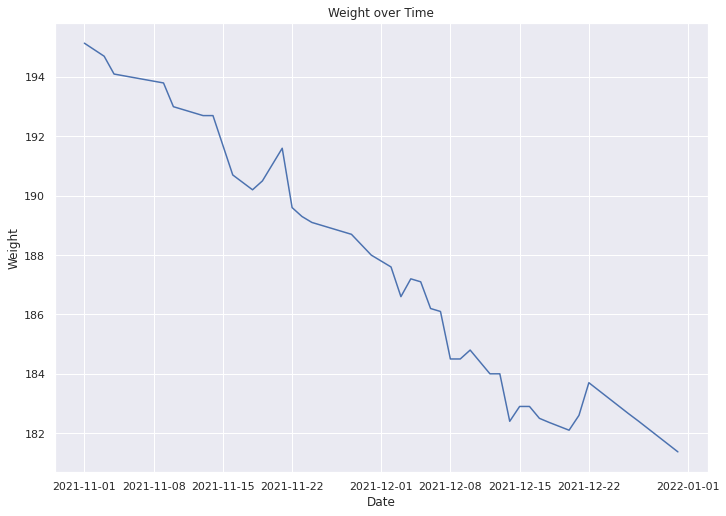

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)});
fig = sns.lineplot(x=df.Date, y=df.Weight);
fig.set_title('Weight over Time');

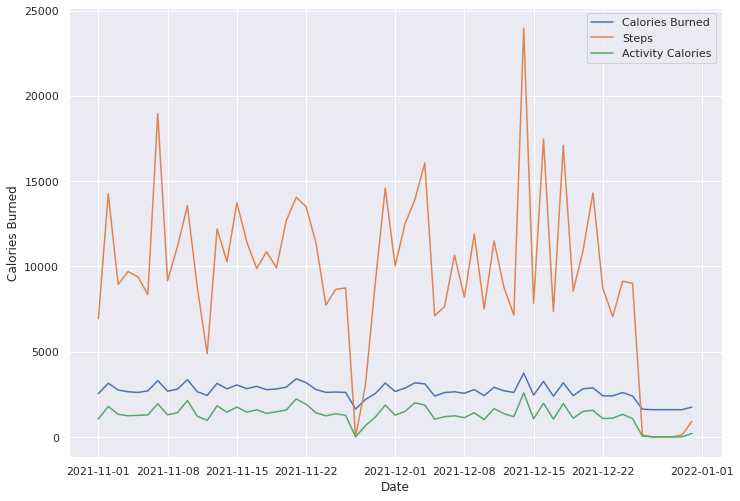

In [37]:
for var in df.columns:
  if var not in ['Date', 'BMI', 'Fat', 'Weight'] and df[var].mean() > 1000:
    sns.lineplot(x = df.Date, y = df[var], label = var)

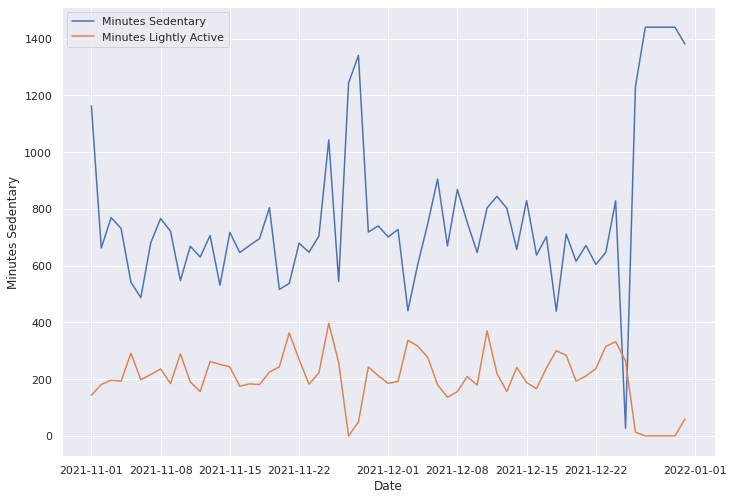

In [38]:
for var in df.columns:
  if var not in ['Date', 'BMI', 'Fat', 'Weight'] and df[var].mean() < 1000 and df[var].mean() > 50:
    sns.lineplot(x = df.Date, y = df[var], label = var)

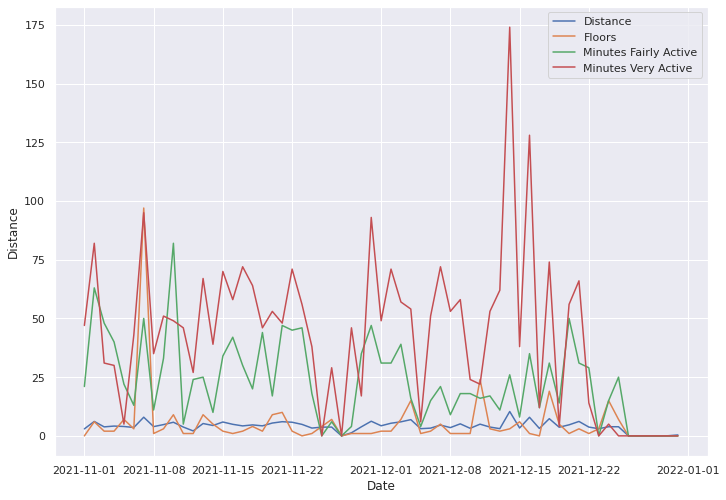

In [39]:
for var in df.columns:
  if var not in ['Date', 'BMI', 'Fat', 'Weight'] and df[var].mean() < 50:
    sns.lineplot(x = df.Date, y = df[var], label = var)

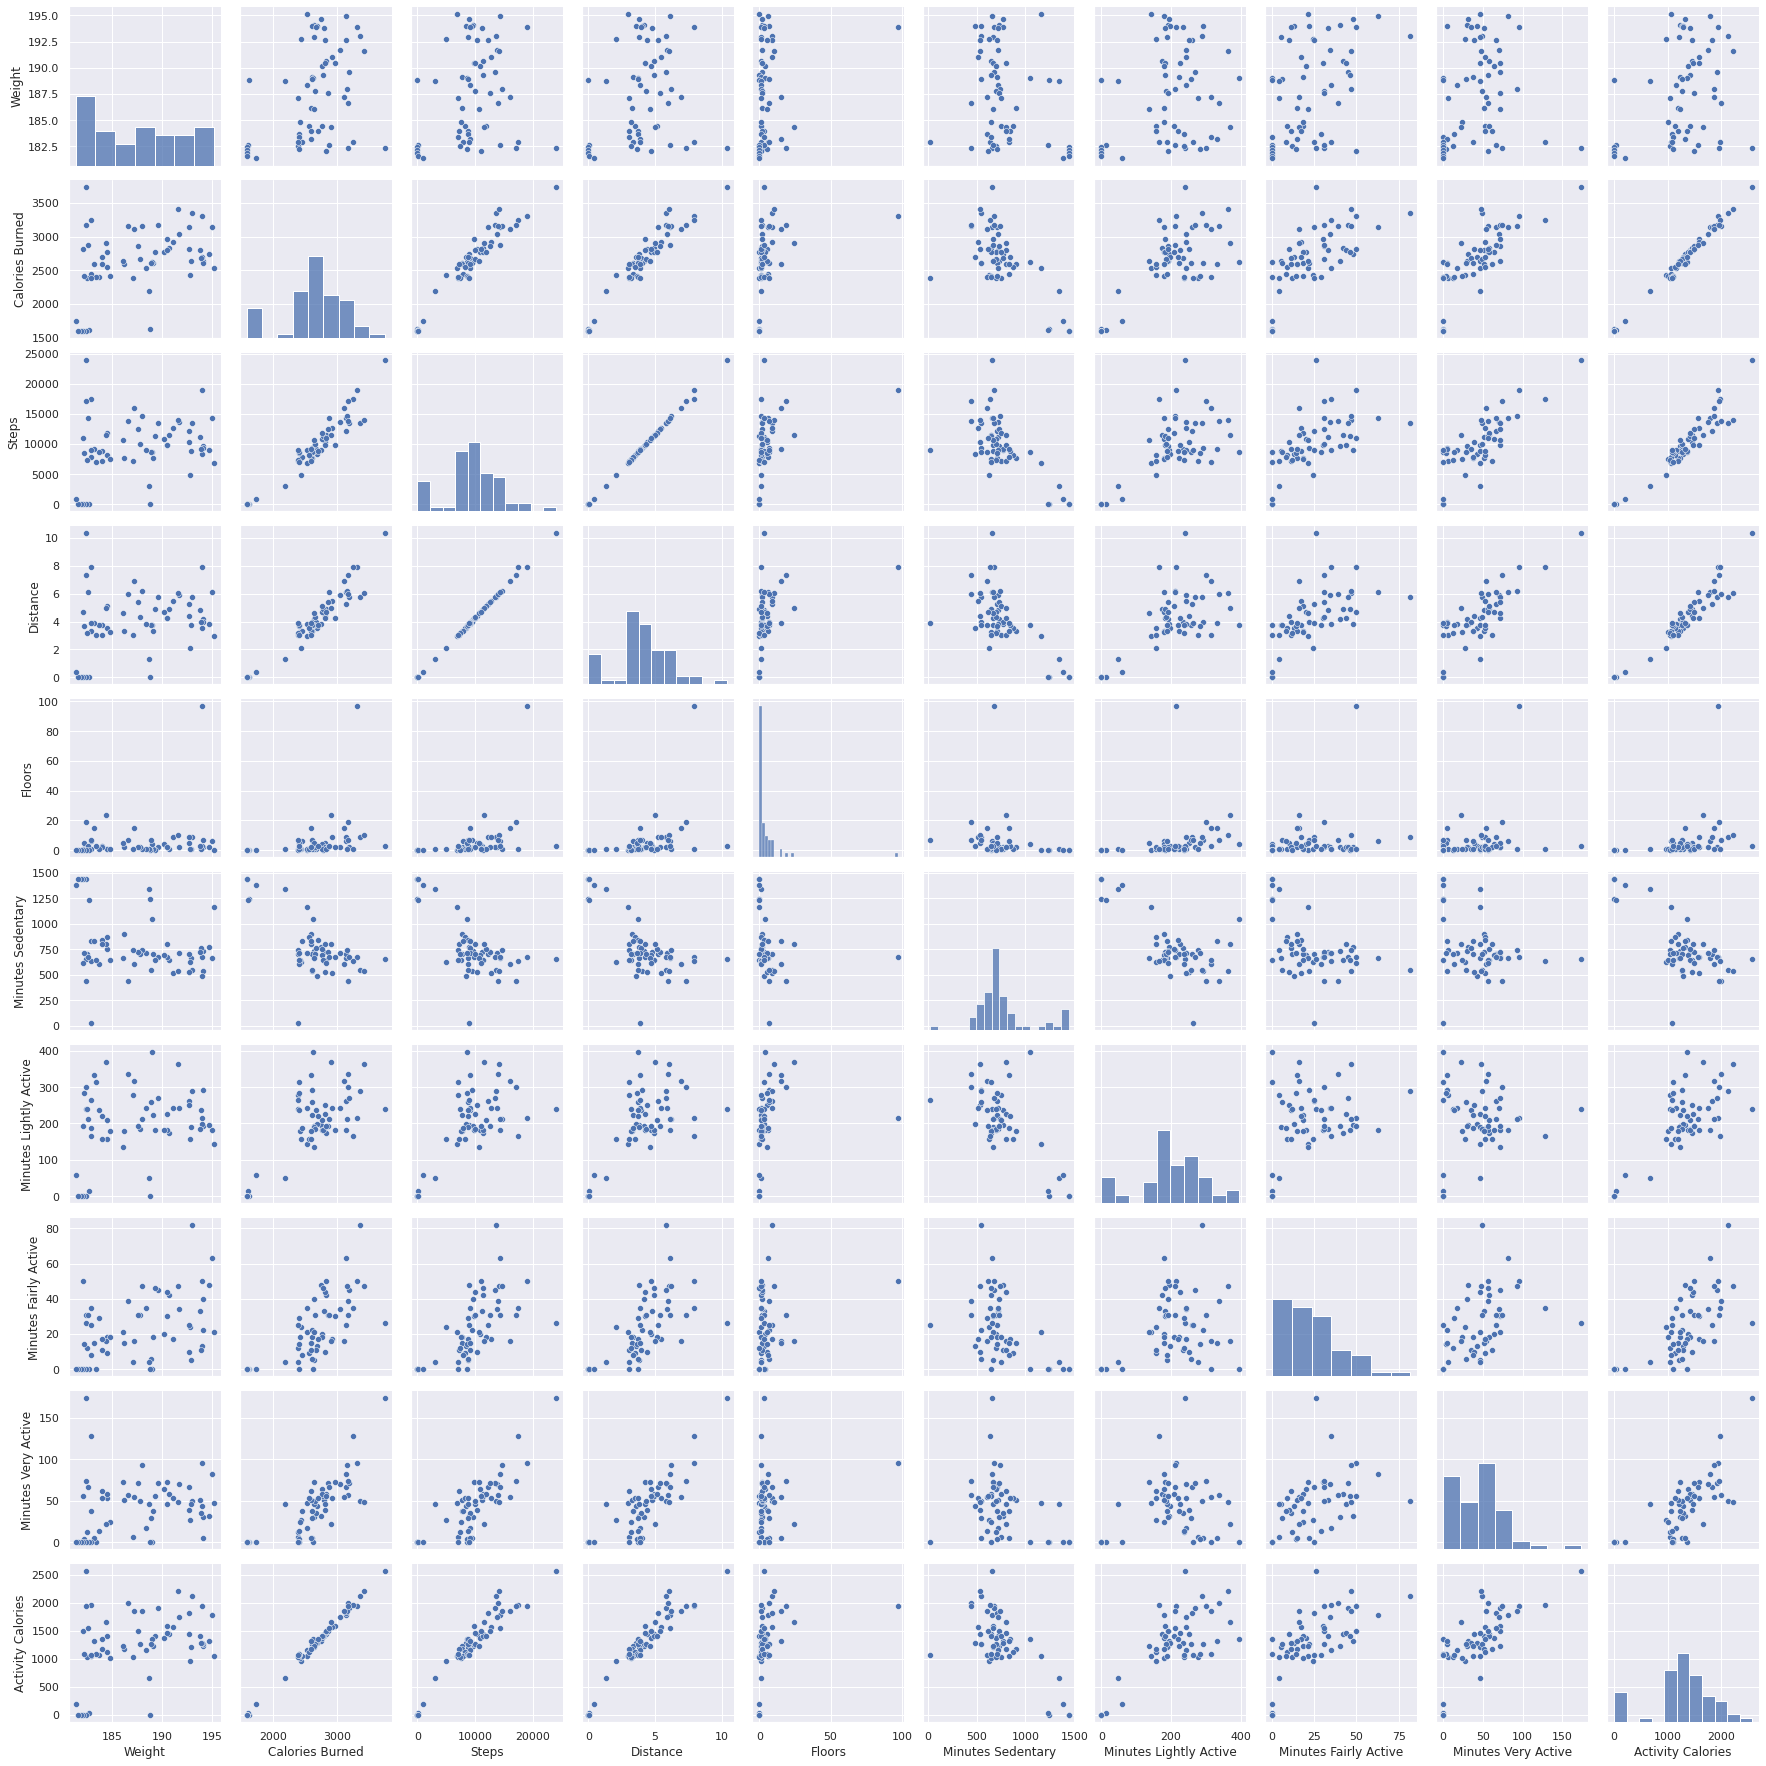

In [40]:
sns.pairplot(df)

### Modeling

In [60]:
#Split data
from sklearn.model_selection import train_test_split

X = df[set(df.columns).difference(set(['Weight', 'Date']))]
y = df['Weight']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

In [61]:
#Fit random forest regressor
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=5, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=0)

In [62]:
#Predict values for RFR
pred_values = rf_model.predict(X_test)

#Show R^2. 
rf_model.score(X_test, y_test, sample_weight=None)

0.25319013512514055

In [63]:
#Feature importance (sums to 1)

fi_spend = pd.DataFrame([(i,j) for i,j in zip(X_train.columns, rf_model.feature_importances_)]).rename(
    columns = {0:'Feature', 1: 'Feature Importance'}).sort_values(by = 'Feature Importance', ascending = False)
fi_spend.head(20)

,Feature,Feature Importance
5,Minutes Fairly Active,0.312821
1,Calories Burned,0.177918
4,Minutes Very Active,0.134626
7,Minutes Sedentary,0.084030
6,Activity Calories,0.081172
0,Minutes Lightly Active,0.073081
8,Steps,0.067251
2,Distance,0.043714
3,Floors,0.025387


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


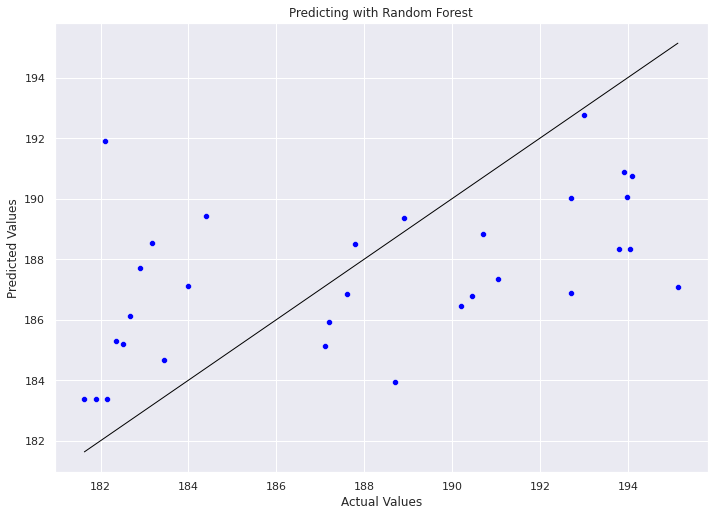

In [64]:
#Plot performance

ax = sns.scatterplot(y_test, pred_values, color = 'blue')
p1 = max(max(pred_values), max(y_test))
p2 = min(min(pred_values), min(y_test))
ax.plot([p1, p2], [p1, p2], linewidth=1, color = 'black')
ax.set_xlabel('Actual Values');
ax.set_ylabel('Predicted Values');
ax.set_title('Predicting with Random Forest');